In [782]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
import neurokit2 as nk
from scipy.optimize import least_squares
from scipy.signal import spectrogram
import copy
import pywt
from pathlib import Path

In [468]:
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)

In [469]:
T_c = 91.72 * (1e-6)   # Chirp time
SAMPLE_PER_CHIRP = 256
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
speed_of_light = 300000000
NUMBER_OF_CHANNEL=4
FPS=20 #20 frame/s
CHIRP_PER_FRAME=2 # 2 chirp/ frame
DURATION=5#minute
FRAME_COUNT = DURATION * 60 * FPS
SAMPLE_PER_FRAME = CHIRP_PER_FRAME *SAMPLE_PER_CHIRP
FFT_SIZE=2**8
RANGE_RESOLUTION =float(speed_of_light)/(2*B)
SAMPLING_RATE = 3000e3;
FREQ_SLOPE =40.8450012207031251e6*1e6
RANGE_BIN =(float(speed_of_light) * SAMPLING_RATE) / (2*FREQ_SLOPE*FFT_SIZE) ;

MAX_RANGE =(SAMPLING_RATE *speed_of_light)/(2*FREQ_SLOPE);

print("Number of frame: {0}".format(FRAME_COUNT))
print("Number of sample per frame: {0}".format(SAMPLE_PER_FRAME))
print("FFT size {0}".format(FFT_SIZE))
print("Range resolution {0}".format(RANGE_RESOLUTION))
print("Range bin {0}".format(RANGE_BIN))
print("Max range {0}".format(MAX_RANGE))

Number of frame: 6000
Number of sample per frame: 512
FFT size 256
Range resolution 0.04
Range bin 0.04303617205204089
Max range 11.017260045322468


In [784]:
PERSON_NUMBER=1

In [785]:
#read data
file_path = '../FMCW Radar/Rawdata/Rawdata_{0}.csv'.format(PERSON_NUMBER)
raw_data = readCsv(file_path)

In [786]:
def readRefFile(pathFile):
    beat_file =open(pathFile)
    beats = [float(br)for br in beat_file.read().split(",")]
    return beats
breaths=readRefFile("../Nihon Kohden/Heart Rate & Breathing Rate/Ref_Breath_{0}.csv".format(PERSON_NUMBER))
heart=readRefFile("../Nihon Kohden/Heart Rate & Breathing Rate/Ref_Heart_{0}.csv".format(PERSON_NUMBER))

In [787]:
print(raw_data.shape)

(4, 3072000)


In [788]:
# reshape(,FRAME_COUNT,SAMPLE_PER_FRAME)SAMPLE_PER_CHIRP
data_channel=raw_data[0]
single_chirp_data =np.array([data_channel[2*i*SAMPLE_PER_CHIRP:SAMPLE_PER_CHIRP*(2*i+1)]for i in range(0,FRAME_COUNT)])
double_chirp_data =np.array([data_channel[SAMPLE_PER_FRAME*i:SAMPLE_PER_FRAME*(i+1)]for i in range(0,FRAME_COUNT)])
print(single_chirp_data.shape)
print(double_chirp_data.shape)

(6000, 256)
(6000, 512)


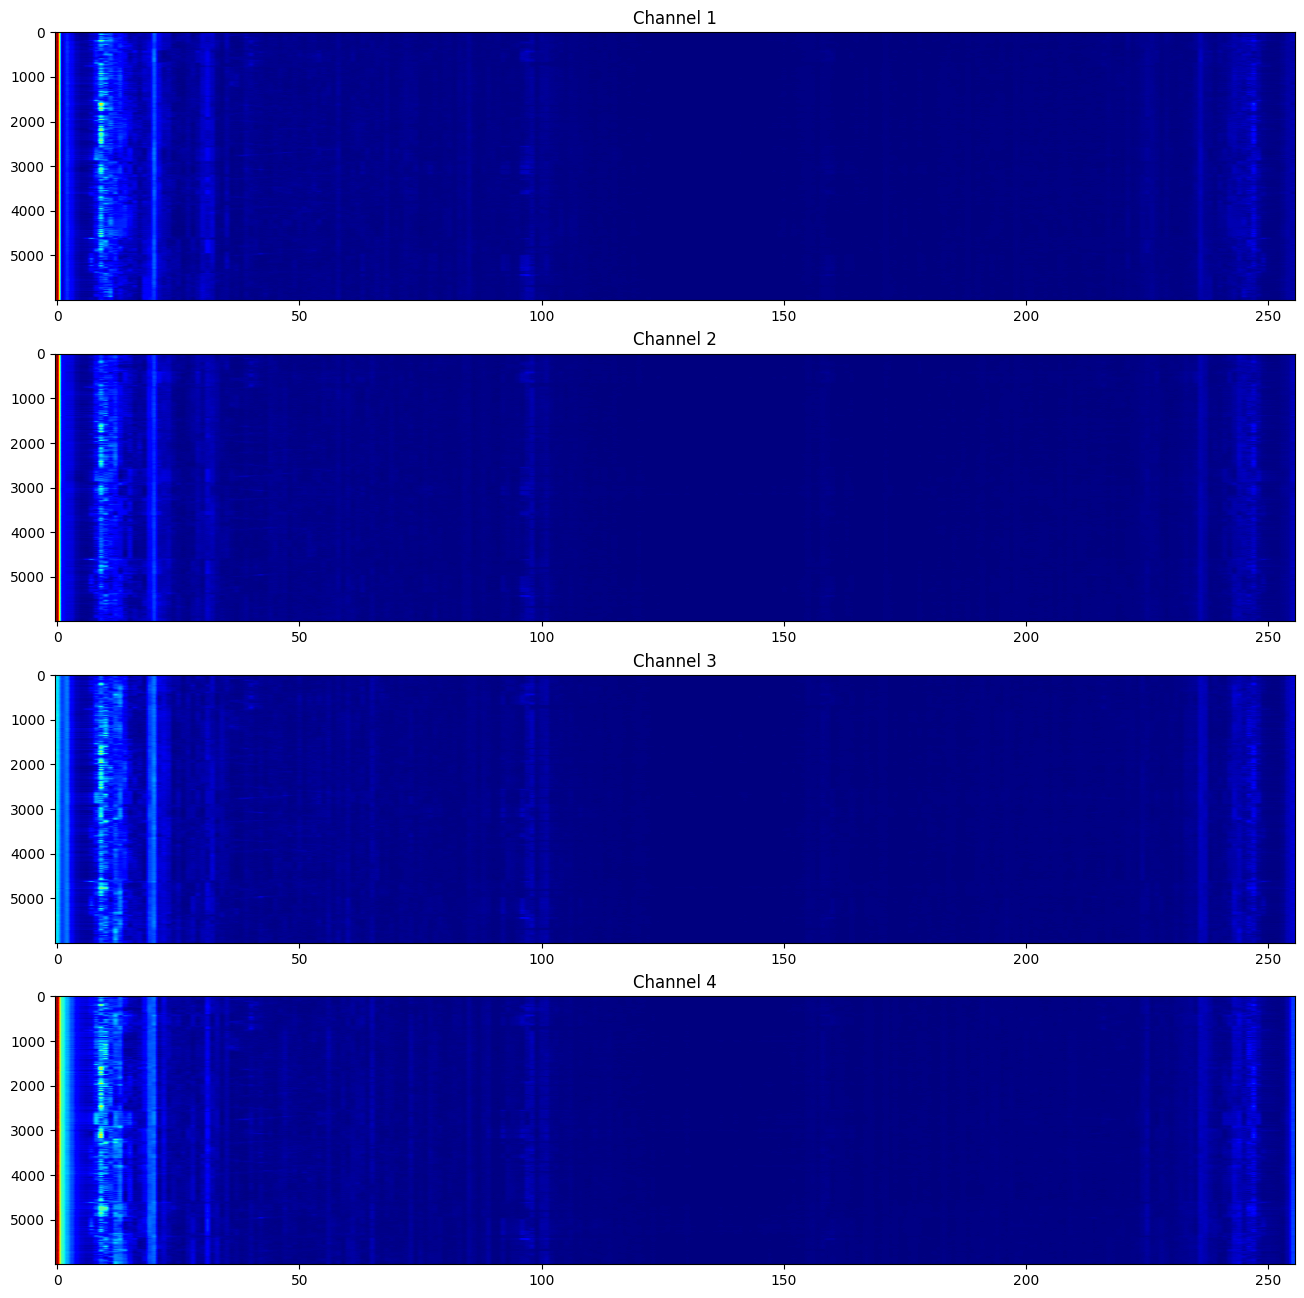

In [789]:
eveluate_channel =[]
for ii in range(0,4):
    tmp_channel=raw_data[ii]
    eveluate_channel.append(np.array([tmp_channel[2*i*SAMPLE_PER_CHIRP:SAMPLE_PER_CHIRP*(2*i+1)]for i in range(0,FRAME_COUNT)]))



plt.figure(figsize=(16,16))
for ii in range(0,4):
    plt.subplot(4,1,ii+1)
    plt.imshow(np.abs(np.fft.fft(eveluate_channel[ii])),cmap='jet',aspect='auto')
    plt.title("Channel {0}".format(ii+1))
plt.show()

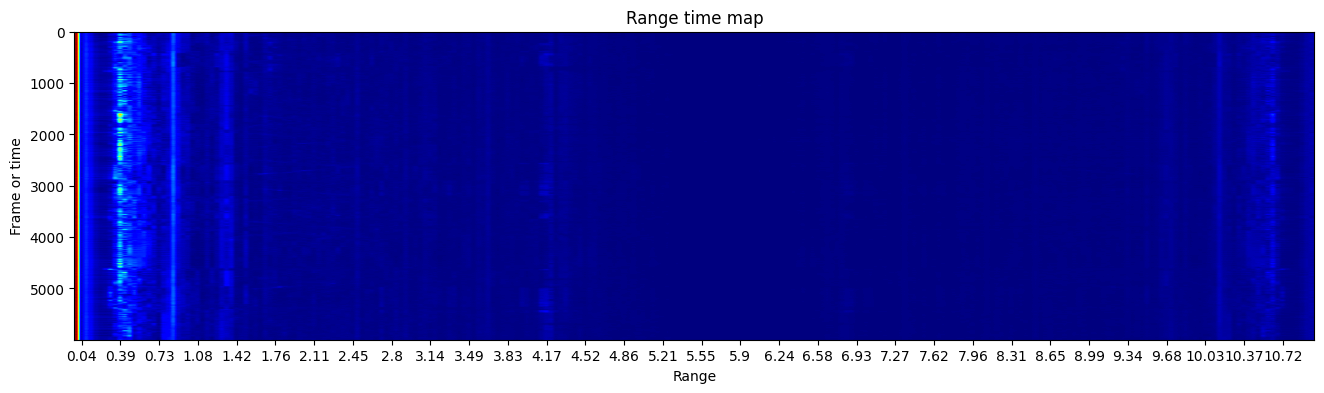

/Users/truongdinh/Downloads/Children Dataset/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


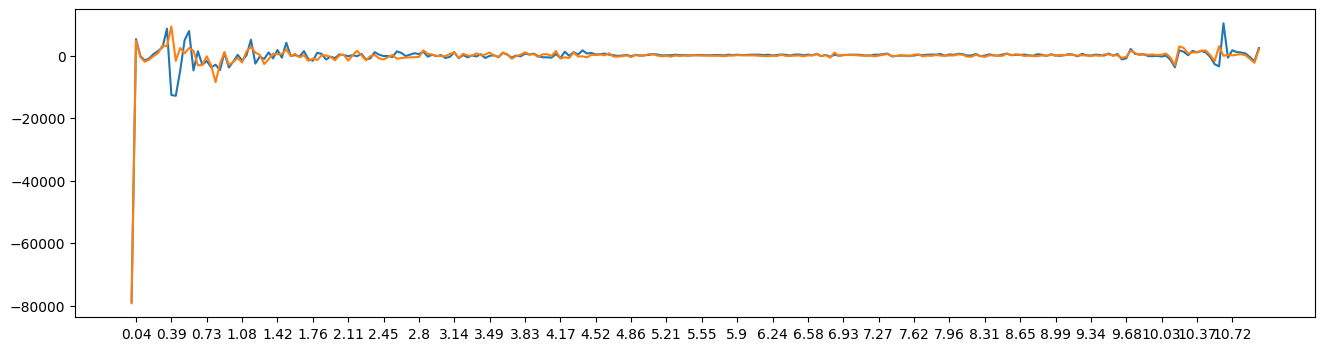

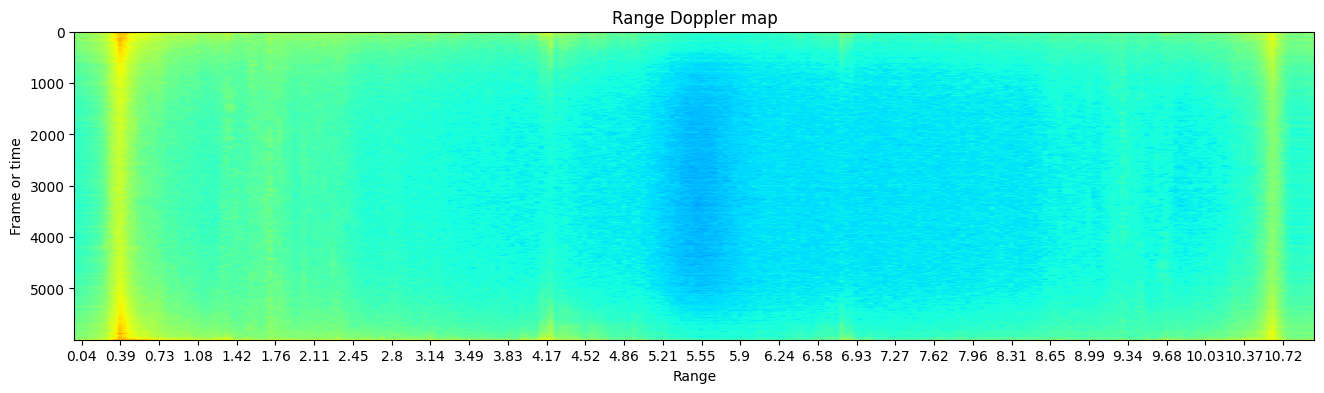

In [790]:
est_channel=single_chirp_data
range_for_plotting =range(1,FFT_SIZE,2**3)
range_bin_distance =[round(j*RANGE_BIN,2) for j in range_for_plotting ]

range_time_matrix=np.fft.fft(est_channel,axis=1)
range_doppler_matrix=np.fft.fft2(est_channel)

mag_range_time_matrix=np.abs(range_time_matrix)
mag_range_doppler_matrix=np.abs(range_doppler_matrix)

plt.figure(figsize=(16,4))
plt.xlabel('Range')
plt.ylabel('Frame or time')
plt.title("Range time map")
plt.imshow(mag_range_time_matrix,cmap='jet',aspect='auto')
plt.xticks(range_for_plotting, range_bin_distance)
plt.show()


plt.figure(figsize=(16,4))
plt.plot(range_time_matrix[0])
plt.plot(range_time_matrix[-1])
plt.xticks(range_for_plotting, range_bin_distance)
plt.show()

column=range_time_matrix.shape[1]
colum_FFT_range_fft_channel_0=np.zeros_like(range_time_matrix)
for c in range(0,column):
    colum_FFT_range_fft_channel_0[:,c] =np.fft.fft(range_time_matrix[:,c])

plt.figure(figsize=(16,4))
plt.xlabel('Range')
plt.ylabel('Frame or time')
plt.title("Range Doppler map")
plt.imshow(np.log(np.abs(colum_FFT_range_fft_channel_0)),cmap='jet',aspect='auto')
plt.xticks(range_for_plotting, range_bin_distance)
plt.show()


In [791]:
#calculate the peak index on each chirp
def get_the_peaks(magnitude_matrix):
    print("shape of input: {0}".format(magnitude_matrix.shape))
    peak_indices=[]
    rows =range(0,magnitude_matrix.shape[0])
    for r in rows:
        peak_index = np.argmax(magnitude_matrix[r,1:])+1
        peak_indices.append(peak_index)
    return peak_indices

In [792]:
peaks = get_the_peaks(mag_range_time_matrix)
counts = np.bincount(peaks)
dominant_bin_index =np.argmax(counts)
print("dominant bin {0} respect to distance {2}m with count {1}".format(dominant_bin_index,counts[dominant_bin_index],dominant_bin_index*RANGE_BIN))

shape of input: (6000, 256)
dominant bin 9 respect to distance 0.38732554846836803m with count 2805


In [793]:
def extract_phase_DACM(complex_signals):
    phases=[]
    phases.append(np.angle(complex_signals[0]))

    for s in range(1,len(complex_signals)):
        phase_s=0
        for k in range(1,s):
            I_k =complex_signals[k].real
            Q_k=complex_signals[k].imag
            I_k_1=complex_signals[k-1].real
            Q_k_1=complex_signals[k-1].imag
            phase_s+=(I_k*(Q_k-Q_k_1) - (I_k -I_k_1)*Q_k)/(I_k**2 +Q_k**2)
        phases.append(phase_s)
    return phases


In [794]:
signal_fixed_bin =est_channel[:,dominant_bin_index]
signal_peak_bin=[]
rows =range(0,est_channel.shape[0])
colums =range(0,est_channel.shape[1])
for r in rows:
    peak_r =peaks[r]
    signal_peak_bin.append(est_channel[r,peak_r])

In [795]:
phase_unwrap_signal_fixed_bin=np.diff(np.unwrap(np.angle(signal_fixed_bin)))
phase_unwrap_signal_peak_bin=np.diff(np.unwrap(np.angle(signal_peak_bin)))
phase_DACM_signal_fixed_bin = np.diff(extract_phase_DACM(signal_fixed_bin))
phase_DACM_signal_peak_bin = np.diff(extract_phase_DACM(signal_peak_bin))


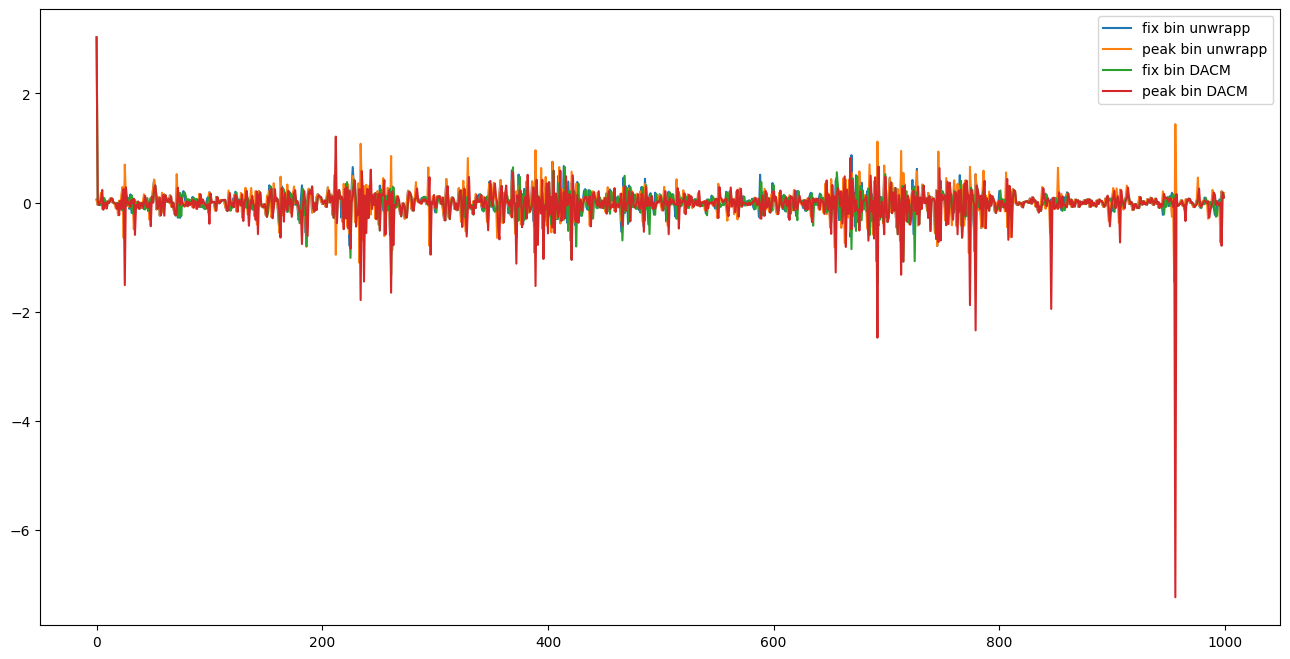

In [796]:
plt.figure(figsize=(16,8))
plt.plot(phase_unwrap_signal_fixed_bin[0:1000],label="fix bin unwrapp")
plt.plot(phase_unwrap_signal_peak_bin[0:1000],label="peak bin unwrapp")

plt.plot(phase_DACM_signal_fixed_bin[0:1000],label="fix bin DACM")
plt.plot(phase_DACM_signal_peak_bin[0:1000],label="peak bin DACM")
plt.legend()
plt.show()


In [797]:
def estSignal(input_signal,sampling_rate,min_freq,max_freq):
    scales = np.arange(1, 128)  # Scales for wavelet transform
    wavelet = 'cmor'  # Complex Morlet wavelet
    # Perform Continuous Wavelet Transform (CWT)
    coefficients, frequencies = pywt.cwt(input_signal, scales, wavelet, sampling_period=1/sampling_rate)
    conditions =(np.where((frequencies >= min_freq) & (frequencies <= max_freq)))
    
    for c in conditions[0]:
        print(c,"  -   ",60* frequencies[c])
    # print(conditions)
    indices = conditions[0][-1]
    # indices=28
    filtered_coeff =coefficients[indices]
    print(indices," -- ",60*frequencies[indices])

    return filtered_coeff

In [798]:
def filter_signal (signal_to_filter ,_low_freq,_high_freq,_sampling_rate,_filter_order):
    sampling_rate = _sampling_rate# Sampling rate of the input signal
    low_freq = _low_freq  # Lower cutoff frequency of the bandpass filter
    high_freq = _high_freq  # Upper cutoff frequency of the bandpass filter
    filter_order = _filter_order # Order of the bandpass filter

    # Compute the normalized cutoff frequencies
    nyquist_freq = 0.5 * sampling_rate
    low_norm = low_freq / nyquist_freq
    high_norm = high_freq / nyquist_freq
    
    # Design the bandpass filter
    b, a = butter(filter_order, [low_norm, high_norm], btype='band')

    # Apply the bandpass filter to the input signal
    signal_filtered = filtfilt(b, a, signal_to_filter)
    return signal_filtered

In [799]:
EXTRACT_SAMPLING_RATE=20
unwrap_fixed_breath=estSignal(phase_unwrap_signal_fixed_bin,EXTRACT_SAMPLING_RATE,float(20/60),float(40/60))
unwrap_peak_breath=estSignal(phase_unwrap_signal_peak_bin,EXTRACT_SAMPLING_RATE,float(20/60),float(40/60))

phase_unwrap_signal_fixed_bin_heart=filter_signal(phase_unwrap_signal_fixed_bin,80/60,100/60,EXTRACT_SAMPLING_RATE,4)
phase_unwrap_signal_peak_bin_heart=filter_signal(phase_unwrap_signal_peak_bin,80/60,100/60,EXTRACT_SAMPLING_RATE,4)
unwrap_fixed_heart=estSignal(phase_unwrap_signal_fixed_bin_heart,EXTRACT_SAMPLING_RATE,float(80/60),float(100/60))
unwrap_peak_heart=estSignal(phase_unwrap_signal_peak_bin_heart,EXTRACT_SAMPLING_RATE,float(80/60),float(100/60))

# dacm_fixed=estSignal(phase_DACM_signal_fixed_bin,20,float(20/60),float(40/60))
# dacm_peak=estSignal(phase_DACM_signal_peak_bin,20,float(20/60),float(40/60))

/Users/truongdinh/Downloads/Children Dataset/lib/python3.11/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


14   -    40.0
15   -    37.5
16   -    35.29411764705882
17   -    33.33333333333333
18   -    31.57894736842105
19   -    30.0
20   -    28.57142857142857
21   -    27.272727272727273
22   -    26.08695652173913
23   -    24.999999999999996
24   -    23.999999999999996
25   -    23.076923076923077
26   -    22.22222222222222
27   -    21.428571428571427
28   -    20.68965517241379
29   -    20.0
29  --  20.0
14   -    40.0
15   -    37.5
16   -    35.29411764705882
17   -    33.33333333333333
18   -    31.57894736842105
19   -    30.0
20   -    28.57142857142857
21   -    27.272727272727273
22   -    26.08695652173913
23   -    24.999999999999996
24   -    23.999999999999996
25   -    23.076923076923077
26   -    22.22222222222222
27   -    21.428571428571427
28   -    20.68965517241379
29   -    20.0
29  --  20.0
5   -    99.99999999999999
6   -    85.71428571428571
6  --  85.71428571428571
5   -    99.99999999999999
6   -    85.71428571428571
6  --  85.71428571428571


In [800]:
# plt.figure(figsize=(16,8))
# plt.plot(unwrap_fixed[0:1200],label="fix bin unwrapp")
# plt.plot(unwrap_peak[0:1200],label="peak bin unwrapp")

# plt.legend()
# plt.show()

In [806]:
def count_peaks(signal_window,rate_of_sampling):
    fft_result = np.fft.fft(signal_window)
    freqs = np.fft.fftfreq(len(signal_window), 1 / rate_of_sampling)
    dominant_frequency = np.abs(freqs[np.argmax(np.abs(fft_result))])
    return dominant_frequency * 60

def estFreq(signal_for_est):
    window_size=1200
    sampling_rate=20
    freq_peaks=[]
    overlap=16
    start_idx = 0
    while start_idx + window_size <= len(signal_for_est):
        end_idx = start_idx + window_size
        window_signal = signal_for_est[start_idx:end_idx]
        freq_peaks.append(count_peaks(window_signal,sampling_rate))
        start_idx += overlap
    print(freq_peaks)
    return freq_peaks

In [807]:
def MAPE(refSignal,actualSignal):
    arrayRef=np.array(refSignal)
    arrayAct=np.array(actualSignal)
    error =1/len(actualSignal)*np.sum(np.abs((arrayAct-arrayRef)/arrayAct))
    print(error)
    return error
    

[16.0, 16.0, 16.0, 16.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 24.0, 24.0, 24.0, 24.0, 24.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 21.0, 21.

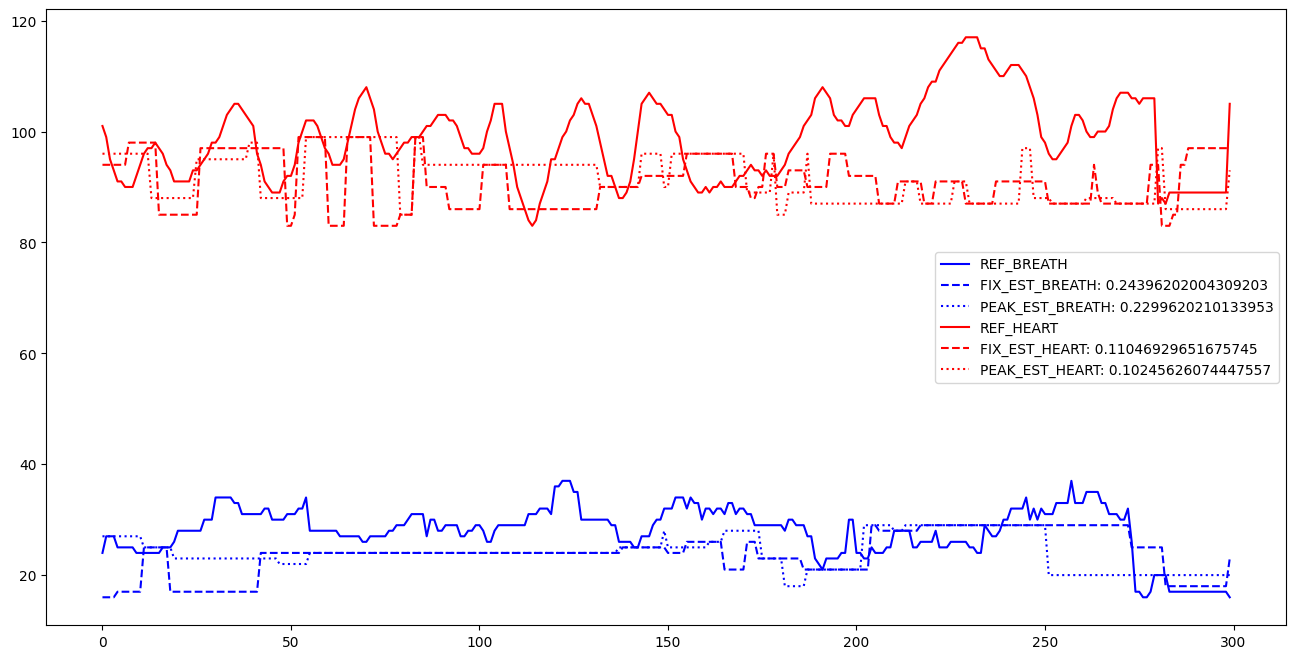

In [808]:
fixed_bin_freq_breath=estFreq(unwrap_fixed_breath)
peak_bin_freq_breath=estFreq(unwrap_peak_breath)

fixed_bin_freq_heart=estFreq(unwrap_fixed_heart)
peak_bin_freq_heart=estFreq(unwrap_peak_heart)

mape_br_fix=MAPE(breaths[0:],fixed_bin_freq_breath[0:])
mape_br_peak=MAPE(breaths[0:],peak_bin_freq_breath[0:])

mape_hr_fix=MAPE(heart[0:],fixed_bin_freq_heart[0:])
mape_hr_peak=MAPE(heart[0:],peak_bin_freq_heart[0:])


plt.figure(figsize=(16,8))
plt.plot(breaths[0:],label="REF_BREATH",color="blue")
plt.plot(fixed_bin_freq_breath[0:],label="FIX_EST_BREATH: {0}".format(mape_br_fix),color="blue",linestyle='--')
plt.plot(peak_bin_freq_breath[0:],label="PEAK_EST_BREATH: {0}".format(mape_br_peak),color="blue",linestyle='dotted')

plt.plot(heart[0:],label="REF_HEART",color="red")
plt.plot(fixed_bin_freq_heart[0:],label="FIX_EST_HEART: {0}".format(mape_hr_fix),color="red",linestyle='--')
plt.plot(peak_bin_freq_heart[0:],label="PEAK_EST_HEART: {0}".format(mape_hr_peak),color="red",linestyle='dotted')
plt.legend()
Path("./RESULT{0}".format(PERSON_NUMBER)).mkdir(parents=True, exist_ok=True)
plt.savefig('./RESULT{0}/WAVELET{0}.png'.format(PERSON_NUMBER))

plt.show()

In [815]:
correlation_coef =np.sqrt(np.mean(np.power((np.array(breaths)-np.array(fixed_bin_freq_breath)),2)))
# correlation_coef = np.corrcoef(breaths, fixed_bin_freq_breath)[0, 1]
print(correlation_coef)

# correlation_coef = np.corrcoef(breaths, peak_bin_freq_breath)[0, 1]
correlation_coef=np.sqrt(np.mean(np.power((np.array(breaths)-np.array(peak_bin_freq_breath)),2)))
print(correlation_coef)

# correlation_coef = np.corrcoef(heart, fixed_bin_freq_heart)[0, 1]
correlation_coef=np.sqrt(np.mean(np.power((np.array(heart)-np.array(fixed_bin_freq_heart)),2)))
print(correlation_coef)

# correlation_coef = np.corrcoef(heart, peak_bin_freq_heart)[0, 1]
correlation_coef=np.sqrt(np.mean(np.power((np.array(heart)-np.array(peak_bin_freq_heart)),2)))
print(correlation_coef)


6.510504332743099
6.369458375717672
11.8673220792786
11.605458485844782


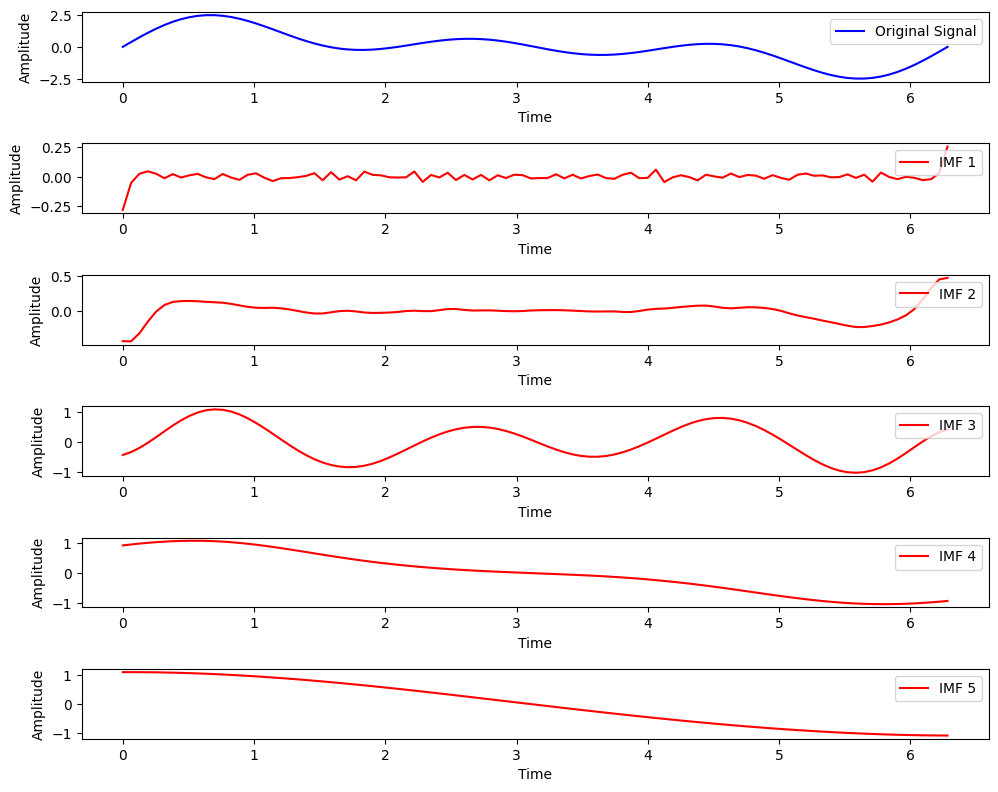

In [809]:
import numpy as np
import matplotlib.pyplot as plt
from PyEMD import EEMD

# Generate example data
t = np.linspace(0, 2 * np.pi, 100)
signal = np.sin(t) + np.sin(2 * t) + np.sin(3 * t)

# Perform EMD
eemd = EEMD()
eemd.trials = 100  # Number of ensemble trials
imfs = eemd.eemd(signal)
residual = signal - np.sum(imfs, axis=0)

# Plot the original signal and its IMFs
plt.figure(figsize=(10, 8))
plt.subplot(len(imfs) + 1, 1, 1)
plt.plot(t, signal, 'b', label='Original Signal')
plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Amplitude')

for i, imf in enumerate(imfs):
    plt.subplot(len(imfs) + 1, 1, i + 2)
    plt.plot(t, imf, 'r', label='IMF {}'.format(i + 1))
    plt.legend(loc='upper right')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

# plt.subplot(len(imfs) + 1, 1, len(imfs) + 2)
# plt.plot(t, residual, 'g', label='Residual')
# plt.legend(loc='upper right')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


In [810]:
import numpy as np

# Example signal parameters
observe_time = 100  # total observation time in seconds
sampling_rate = 100  # samples per second
window_size = 1000  # size of the sliding window

# Generate the time array
t = np.linspace(0, observe_time, observe_time * sampling_rate)

# Generate the signal (sine wave with frequency 9 Hz and a Gaussian noise)
signal = 0.5 * np.sin(2 * np.pi * 12.9 * t) 

# Define a function to count peaks within a window
def count_peaks(signal_window,rate_of_sampling):
    # Find peaks using simple peak detection (local maxima)
    peaks = np.where((signal_window[1:-1] > signal_window[:-2]) & (signal_window[1:-1] > signal_window[2:]))[0]
    peaks_count =len(peaks)/(len(signal_window)/rate_of_sampling)
    return peaks_count

# Initialize an array to store the number of peaks within each window
num_peaks = []

# Iterate over each window and count peaks
for i in range(len(signal) - window_size + 1):
    window_signal = signal[i:i+window_size]
    peakcount=count_peaks(window_signal,sampling_rate)
    num_peaks.append(peakcount)
    

# Print the number of peaks within each window
print("Number of peaks within each window:", num_peaks)


Number of peaks within each window: [12.9, 12.9, 12.8, 12.8, 12.9, 12.9, 12.9, 12.9, 12.9, 12.9, 12.8, 12.8, 12.9, 12.9, 12.9, 12.9, 12.9, 12.8, 12.8, 12.9, 12.9, 12.9, 12.9, 12.9, 12.9, 12.8, 12.8, 12.9, 12.9, 12.9, 12.9, 12.9, 12.9, 12.8, 12.8, 12.9, 12.9, 12.9, 12.9, 12.9, 12.9, 12.8, 12.8, 12.9, 12.9, 12.9, 12.9, 12.9, 12.8, 12.8, 12.9, 12.9, 12.9, 12.9, 12.9, 12.9, 12.8, 12.8, 12.9, 12.9, 12.9, 12.9, 12.9, 12.9, 12.8, 12.8, 12.9, 12.9, 12.9, 12.9, 12.9, 12.9, 12.8, 12.8, 12.9, 12.9, 12.9, 12.9, 12.9, 12.8, 12.8, 12.9, 12.9, 12.9, 12.9, 12.9, 12.9, 12.8, 12.8, 12.9, 12.9, 12.9, 12.9, 12.9, 12.9, 12.8, 12.8, 12.9, 12.9, 12.9, 12.9, 12.9, 12.9, 12.8, 12.8, 12.9, 12.9, 12.9, 12.9, 12.9, 12.8, 12.8, 12.9, 12.9, 12.9, 12.9, 12.9, 12.9, 12.8, 12.8, 12.9, 12.9, 12.9, 12.9, 12.9, 12.9, 12.8, 12.8, 12.9, 12.9, 12.9, 12.9, 12.9, 12.9, 12.8, 12.8, 12.9, 12.9, 12.9, 12.9, 12.9, 12.8, 12.8, 12.9, 12.9, 12.9, 12.9, 12.9, 12.9, 12.8, 12.8, 12.9, 12.9, 12.9, 12.9, 12.9, 12.9, 12.8, 12.8, 12.9, 12.

In [ ]:
import numpy as np

# Define two example signals
signal1 = np.array([1, 2, 3, 4, 5])
signal2 = np.array([1.2, 2.1, 2.9, 4.2, 4.8])

# Calculate the difference between the signals
diff = signal1 - signal2

# Calculate the squared error
squared_error = diff ** 2

# Calculate the mean squared error
mse = np.mean(squared_error)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)
